# Predefined functions

In [2]:
import pandas as pd

# Getting data
def getData(url, sheet_name=0, skiprows=0, truncate=-1, index_column='County Name'):
    df = pd.read_excel(url, sheet_name=sheet_name, skiprows=skiprows)
    if truncate > -1:
        df = df.truncate(before=0, after=truncate)
    df = df.set_index(index_column)
    return df

In [3]:
def config_subplot(ax, label, fontsize=12, ticker_count=3):
    # axis label
    ax.set_title(label, fontdict={'fontsize':fontsize})
    # number of tickers
    ax.xaxis.set_major_locator(ticker.MaxNLocator(ticker_count))
    # ticker formatter
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))

# Data collection

## Cumulative case count

In [4]:
url = "https://dshs.texas.gov/coronavirus/TexasCOVID19DailyCountyCaseCountData.xlsx"
cases_df = getData(url, skiprows=2, truncate=253)

In [5]:
import re
pattern = re.compile('[0-9]+-[0-9]+', re.IGNORECASE)
cases_df.columns = [pattern.findall(sub)[0] for sub in cases_df.keys()]

from datetime import datetime
dates = [datetime.strptime(date, '%m-%d') for date in cases_df.keys()]

### Scale the data down to per 100k capita

In [6]:
pop_url = "https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/totals/co-est2019-alldata.csv"
pop_df = pd.read_csv(pop_url, engine='python')
pop_df = pop_df.rename(columns={'CTYNAME': 'County Name'})
pop_df = pop_df.set_index('County Name')
# filter Texas counties
pop_df = pop_df[pop_df['STNAME'] == 'Texas']
# get latest population
pop_df = pop_df[pop_df.filter(like='2019').columns[0]]
# remove suffix ' County' in name
pop_df.index = pop_df.index.map(lambda x: x.replace(' County', ''))

In [7]:
scaled_cases_df = cases_df.apply(lambda row: row * 1e5 / pop_df[row.index])
scaled_cases_df.shape

(254, 207)

## Metro / Non-metro

In [8]:
metro_url = "http://www.dshs.state.tx.us/chs/info/TxCoPhrMsa.xls"
metro_df = getData(metro_url, truncate=253)
metro_df = metro_df[[metro_df.filter(like='2013').columns[0], metro_df.filter(like='Metro Area').columns[0]]]
#metro_df

In [9]:
# population
merged_df = pd.merge(pop_df, metro_df, on='County Name', how='inner')
# metro classificiation
merged_df = pd.merge(merged_df, scaled_cases_df, on='County Name', how='outer')
# rename column
keys = merged_df.keys()
merged_df = merged_df.rename(columns={keys[0]: 'Population', keys[1]: 'Classification', keys[2]: 'MetroArea'})
merged_df

,Population,Classification,MetroArea,03-04,03-05,03-06,03-09,03-10,03-11,03-12,...,09-20,09-21,09-22,09-23,09-24,09-25,09-26,09-27,09-28,09-29
County Name,,,,,,,,,,,,,,,,,,,,,
Anderson,57735,Micropolitan,Non-Metro,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3015.501862,4835.888109,4851.476574,4887.849658,4893.045813,4905.170174,4919.026587,4919.026587,4919.026587,4891.313761
Andrews,18705,Micropolitan,Non-Metro,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2202.619620,2202.619620,2202.619620,2218.658113,2218.658113,2272.119754,2272.119754,2272.119754,2272.119754,2272.119754
Angelina,86715,Micropolitan,Non-Metro,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2436.717984,2436.717984,2444.790405,2444.790405,2444.790405,2472.467278,2472.467278,2472.467278,2472.467278,2482.846105
Aransas,23510,Medium Metro,Metro,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1344.108890,1356.869417,1361.122926,1361.122926,1369.629945,1369.629945,1373.883454,1373.883454,1373.883454,1373.883454
Archer,8553,Small Metro,Metro,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,806.734479,806.734479,923.652520,923.652520,958.727932,993.803344,1017.186952,1017.186952,1017.186952,1017.186952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wood,45539,Non-core,Non-Metro,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1089.176310,1089.176310,1113.331430,1126.506950,1126.506950,1139.682470,1152.857990,1152.857990,1152.857990,1155.053910
Yoakum,8713,Non-core,Non-Metro,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2306.897739,2306.897739,2329.851945,2329.851945,2444.622977,2536.439803,2570.871112,2570.871112,2570.871112,2570.871112
Young,18010,Non-core,Non-Metro,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1476.957246,1476.957246,1565.796780,1632.426430,1671.293726,1687.951138,1743.475847,1743.475847,1743.475847,1815.657968


# Plotting

In [10]:
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.dates as mdates

figsize=(20,10)
title_size = 22
label_size = 18
ticker_count= 8
line_width = 2.5

## 7-day average case count

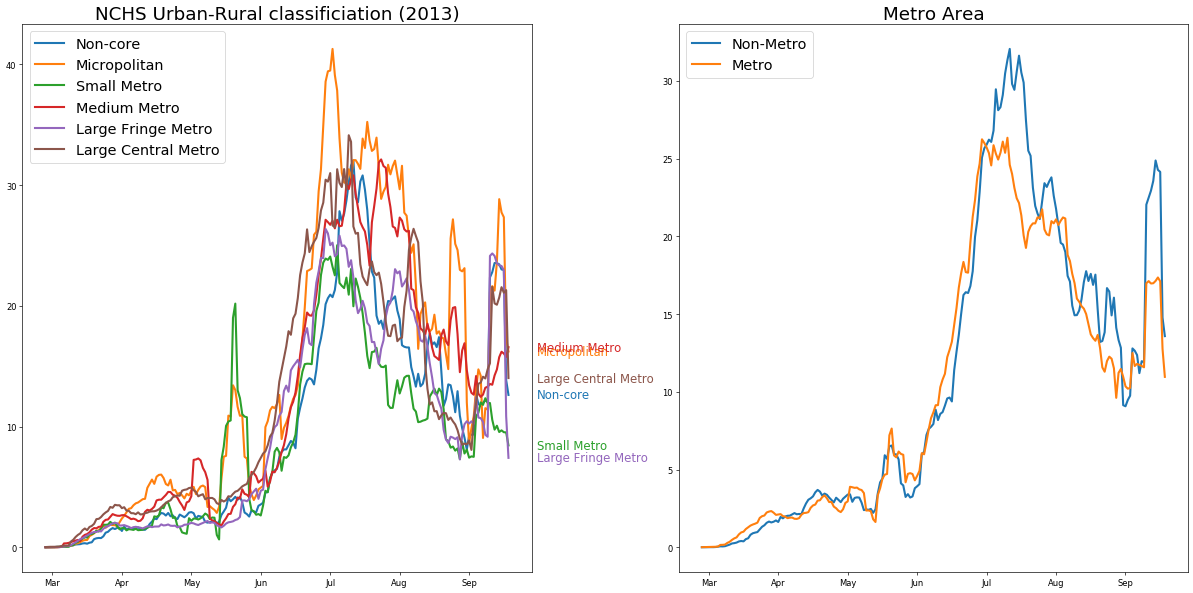

In [24]:
# create figure
fig = plt.figure(figsize=figsize, dpi=60)
#fig.suptitle('Daily case count per 100,000 of population', fontsize=32)
# and its subplots
ax1 = fig.add_subplot(1, 2, 1)
config_subplot(ax1, 'NCHS Urban-Rural classificiation (2013)', title_size, ticker_count)
ax2 = fig.add_subplot(1, 2, 2)
config_subplot(ax2, 'Metro Area', title_size, ticker_count)

# plotting average values of each metro classification
# for label, df in merged_df.groupby('Classification', sort=True):
metro_cls = ['Non-core', 'Micropolitan', 'Small Metro', 'Medium Metro', 'Large Fringe Metro', 'Large Central Metro']
for cls in metro_cls:
    df = merged_df[merged_df['Classification'] == cls].iloc[:,3:]
    df = df.mean().diff().rolling(window=7).mean()
    #print(df.iloc[:,:-1].max().max())
    ax1.plot(dates, df, label=cls, linewidth=line_width)

# plotting average values of each metro classification
metro_types = ['Non-Metro', 'Metro']
for metro_type in metro_types:
    df = merged_df[merged_df['MetroArea'] == metro_type].iloc[:,3:]
    df = df.mean().diff().rolling(window=7).mean()
    ax2.plot(dates, df, label=metro_type, linewidth=line_width)

# using same ylim
# ax1.set_ylim(0, 45);
# ax2.set_ylim(0, 45);
    
# configure legend
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc='upper left', fontsize='xx-large')
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels, loc='upper left', fontsize='xx-large')

# configure legend on lines
for line, name in zip(ax1.lines, metro_cls):
    y = line.get_ydata()[-1]
    ax1.annotate(name, xy=(1,y), xytext=(6,0), color=line.get_color(), 
                xycoords = ax1.get_yaxis_transform(), textcoords="offset points",
                size=14, va="center")
    
fig.tight_layout()

fig.savefig('graphs/hypothesis_8_1.png')

Contrary to the hypothesis, the daily number of new cases of rural counties appears to be a little higher than those urban ones, especially with micropolitan counties top the graph during the outbreak period. Small-metro counties seems to has least spread, while other types are somewhat similar to each other.

When we combine them into 2 main caterogies metro or non-metro, it even becomes clearer when those metro counties are almost always equal or lower than non-metro counterparts.

## Heatmap

In [12]:
import calendar

avg_month_df = merged_df.iloc[:,:3]
for month in range(1,12,1):
    df = merged_df.filter(like='{:02d}-'.format(month))
    if df.shape[1] > 0:
        avg_month_df[calendar.month_name[month]] = df.mean(axis=1).values
# avg_month_df

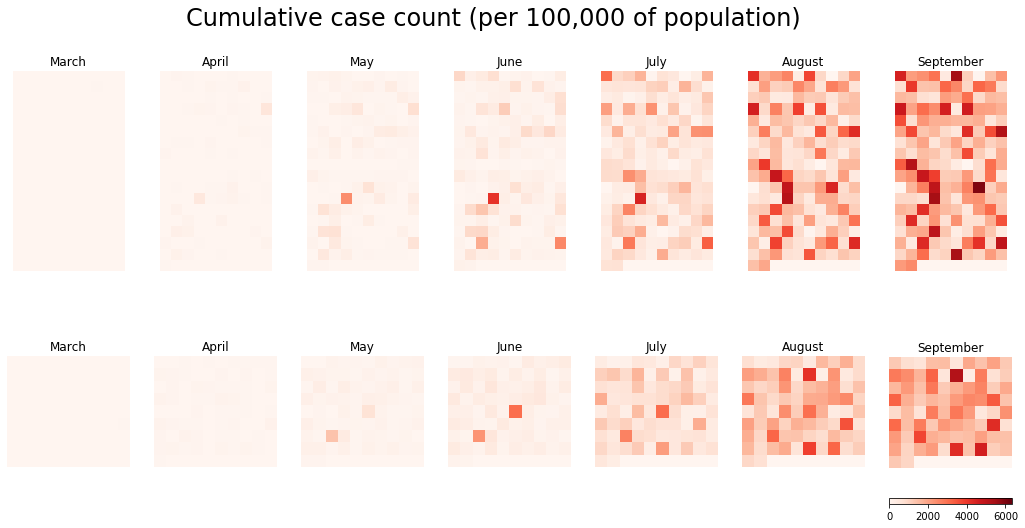

In [56]:
import numpy as np
from matplotlib.pyplot import cm

fig_size = 6
fig2 = plt.figure(figsize=(fig_size*3, fig_size*1.5))
fig2.suptitle('Cumulative case count (per 100,000 of population)', fontsize=24)
# fig2.text(0.085, 0.5, "Cumulative case count (per 100,000 of population)", va="center", rotation=90, fontsize=14)

idx = 0
vmax = merged_df.iloc[:,3:].max().max()
for i, metro_type in enumerate(metro_types):
    avg_month_type_df = avg_month_df[avg_month_df['MetroArea'] == metro_type].iloc[:,3:]
    for month in avg_month_type_df:
        col = avg_month_type_df[month].values
        col = np.pad(col, (0, 10 - col.shape[0] % 10), 'constant')
        col = col.reshape((-1,10))
            
        idx += 1
        ax = fig2.add_subplot(2, 7, idx)
        ax.set_title(month, fontdict={'fontsize':12})
        heatmap = ax.imshow(col, cmap=cm.Reds, vmax=vmax)
        ax.set_axis_off()
        
# configure colorbar
fig2.subplots_adjust(bottom=0.2)
fig2.colorbar(heatmap, orientation="horizontal", fraction=0.07,anchor=(1.0,0.0))

fig2.savefig('graphs/hypothesis_8_2.png')

Looking at corresponding heatmap of those two types, we can clearly see that there is also way many more counties with darker color in non-metro type, indicating greater spread compared to metro counties.

## Scatterplot

In [59]:
avg_month_df

,Population,Classification,MetroArea,March,April,May,June,July,August,September
County Name,,,,,,,,,,
Anderson,57735,Micropolitan,Non-Metro,0.000000,14.087353,90.904773,951.011807,3058.803152,4174.579628,4542.813031
Andrews,18705,Micropolitan,Non-Metro,0.000000,71.103983,122.099490,204.401675,915.918635,1733.536832,2151.370185
Angelina,86715,Micropolitan,Non-Metro,0.599666,26.216149,153.748003,385.208249,1112.506115,2162.739266,2396.316113
Aransas,23510,Medium Metro,Metro,0.000000,6.947398,14.132627,34.878775,341.790041,785.664302,1272.972616
Archer,8553,Small Metro,Metro,0.000000,0.000000,6.411634,38.193227,137.284409,374.892039,809.153473
...,...,...,...,...,...,...,...,...,...,...
Wood,45539,Non-core,Non-Metro,0.000000,11.052797,39.526560,130.657239,366.435292,772.538816,1026.479009
Yoakum,8713,Non-core,Non-Metro,0.000000,4.973411,25.916039,121.657294,572.374242,1369.847799,2186.190275
Young,18010,Non-core,Non-Metro,1.110494,19.618730,22.209883,76.068851,374.344002,1068.044635,1453.981505


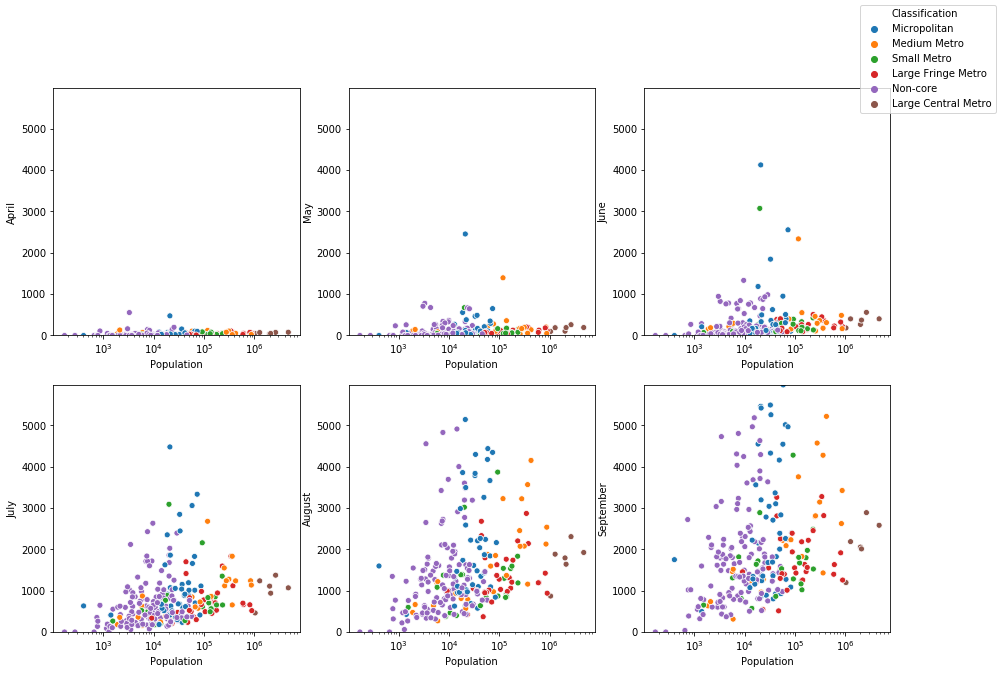

In [18]:
import seaborn as sns

cols=3
fig3, axes = plt.subplots(2, cols, figsize=(15,10))
fig3.suptitle('', fontsize=32)

max = avg_month_df.iloc[:,3:].max().max()
for month in range(4, 10, 1):
    idx = month - 4
    ax = axes[int(idx/cols)][idx%cols]
    ax.set_ylim(0, max);
    g = sns.scatterplot(data=avg_month_df, x="Population", y=calendar.month_name[month], 
                        hue='Classification', ax=ax)
    g.set(xscale="log")
    ax.get_legend().remove()
#     plt.setp(ax.get_legend().get_texts(), fontsize='7')
    
handles, labels = axes[1][2].get_legend_handles_labels()
fig3.legend(handles, labels, loc='upper right')

fig3.savefig('graphs/hypothesis_8_3.png')

# Performing statistical tests

Null hypothesis (H0): There is no difference between spread rate of rural and urban counties.  
Alternative hypothesis (H1): Rural counties had less spread.

In [ ]:
from scipy import stats
import time
np.random.seed(int(time.time()))

# Paired T-Test

In [ ]:
case_metro_df = merged_df[merged_df['MetroArea'] == 'Metro'].iloc[:,3:]
case_non_metro_df = merged_df[merged_df['MetroArea'] == 'Non-Metro'].iloc[:,3:]

In [ ]:
# stats.ttest_ind(case_non_metro_df.mean(), case_metro_df.mean(), equal_var = False)
stats.ttest_rel(case_non_metro_df.mean(), case_metro_df.mean())

The p-value is 0.001, which is less than the stardard threshold 0.05 and 0.01, so we reject the null hypothesis and we can say that rural counties had less spread.

In [ ]:
#stats.chisquare(case_metro_df.mean(), case_non_metro_df.mean(), ddof=case_metro_df.shape[0]-1)
#stats.chisquare(case_metro_df.iloc[:,30:].mean(), case_non_metro_df.iloc[:,30:].mean(), ddof=case_metro_df.shape[0]-1)

# ANOVA

In [ ]:
cls = merged_df['Classification']
rural = merged_df[cls.isin(['Non-core', 'Micropolitan'])].iloc[:,3:]
mixed = merged_df[cls.isin(['Small Metro', 'Medium Metro'])].iloc[:,3:]
urban = merged_df[cls.isin(['Large Fringe Metro', 'Large Central Metro'])].iloc[:,3:]
stats.f_oneway(rural.mean(), mixed.mean(), urban.mean())

In [ ]:
stats.f_oneway(*merged_df.groupby('Classification').mean().values)